In [5]:
!pip install transformers datasets peft accelerate evaluate matplotlib sentencepiece

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached torch-2.7.0-cp310-cp310-win_amd64.whl.metadata (29 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   -------- ------------------------------- 2.1/10.5 MB 13.0 MB/s eta 0:00:01
   ----------------------- ---------------- 6.0/10.5 MB 17.6 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.5 MB 18.8 MB/s eta 0:00:01
   ---------------------------------------- 10.5/10.5 MB 15.5 MB/s eta 0:00:00
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
Using cached torch-2.7.0-cp310-cp310-win_amd64.whl (212.5 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   --------------------------

In [6]:
import json
import torch
import re
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType

In [28]:
# Load the .jsonl files
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return data

train_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_train.jsonl")
val_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_dev.jsonl")
test_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_test.jsonl")

In [29]:
import random

def sample_data(dataset, num_samples):
    return random.sample(dataset, num_samples)

train_data_sampled = sample_data(train_data, 24000)
val_data_sampled = sample_data(val_data, 4500)
test_data_sampled = sample_data(test_data, 1500)

In [30]:
# Convert to Hugging Face dataset format
train_dataset = Dataset.from_list(train_data_sampled)
val_dataset = Dataset.from_list(val_data_sampled)
test_dataset = Dataset.from_list(test_data_sampled)

# Create DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [31]:
# Clean Text Function
def clean_text(sample):
    text = re.sub(r"[.]{2,}", ".", sample['text'])  # Remove multiple dots
    text = re.sub(r"_+", "", text)  # Remove blank spaces or underscores
    return {'text': text.strip(), 'title': sample['title'].strip()}

# Apply cleaning function
dataset = dataset.map(clean_text)

Map: 100%|████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 9170.87 examples/s]


In [32]:
# Tokenizer & Model
model_name = "ai4bharat/IndicBART-XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)
model = get_peft_model(base_model, lora_config)

# Tokenize the dataset
def preprocess(batch):
    inputs = [f"<2hi> {text}" for text in batch['text']]
    targets = batch['title']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=32, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized = dataset.map(preprocess, batched=True, remove_columns=['id', 'url', 'category'])

Map: 100%|████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1336.27 examples/s]


In [12]:
!pip install rouge_score
!pip install bert-score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
Using cached absl_py-2.2.2-py3-none-any.whl (135 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=25024 sha256=2d913ac92d50a902dc3fb482575b44aac2411d5290a20131dbbeab9fb15c2c4a
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\5f\dd\89\461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score

   ---------------------------

In [46]:
import evaluate

# Load all metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute metrics
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="hi")

    return {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"],
        "meteor": meteor_result["meteor"],
        "bertscore_f1": sum(bertscore_result["f1"]) / len(bertscore_result["f1"]),
    }


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [47]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./indicbart_lora_hindi_copy",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=15,
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none"
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['validation'],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2164\1243193004.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
# Training
history = trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor,Bertscore F1
1,5.686000,5.199738,0.583106,0.186337,0.552581,0.199827,0.259128,0.745253
2,5.305000,5.114828,0.586495,0.187104,0.553591,0.205168,0.266073,0.748857
3,5.250200,5.084644,0.587513,0.187500,0.552590,0.208055,0.270165,0.749811
4,5.225500,5.066056,0.588272,0.188039,0.552591,0.208996,0.272915,0.750748
5,5.207300,5.054952,0.587691,0.188024,0.552481,0.211888,0.275787,0.751855
6,5.194700,5.046422,0.589039,0.188081,0.552955,0.212069,0.277672,0.752794
7,5.185200,5.038649,0.588890,0.190134,0.552218,0.212621,0.278913,0.753191
8,5.178000,5.032969,0.589219,0.191320,0.551872,0.212152,0.277364,0.752797
9,5.172600,5.029550,0.589221,0.192593,0.551751,0.213523,0.280015,0.753598
10,5.168200,5.025613,0.589408,0.192495,0.551827,0.213968,0.280626,0.753812


In [12]:
trainer.save_model("./working/checkpoints/indicbart_hindi_headlines_copy")
tokenizer.save_pretrained("./working/checkpoints/indicbart_hindi_headlines_copy")

('./working/checkpoints/indicbart_hindi_headlines_copy\\tokenizer_config.json',
 './working/checkpoints/indicbart_hindi_headlines_copy\\special_tokens_map.json',
 './working/checkpoints/indicbart_hindi_headlines_copy\\spiece.model',
 './working/checkpoints/indicbart_hindi_headlines_copy\\added_tokens.json',
 './working/checkpoints/indicbart_hindi_headlines_copy\\tokenizer.json')

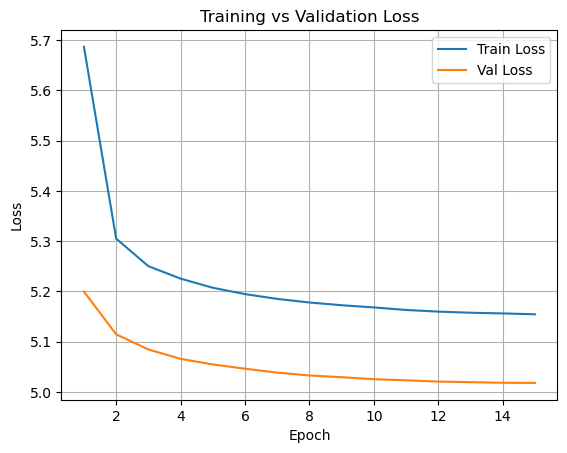

In [13]:
import matplotlib.pyplot as plt

train_loss = []
train_epochs = []
val_loss = []
val_epochs = []

for log in trainer.state.log_history:
    if 'loss' in log and 'eval_loss' not in log:
        train_loss.append(log['loss'])
        train_epochs.append(log.get('epoch', len(train_epochs)))
    elif 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        val_epochs.append(log.get('epoch', len(val_epochs)))

plt.plot(train_epochs, train_loss, label="Train Loss")
plt.plot(val_epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("./working/checkpoints/indicbart_hindi_headlines")
tokenizer = AutoTokenizer.from_pretrained("./working/checkpoints/indicbart_hindi_headlines")

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized['test'])
print(f"Test results: {test_results}")


Test results: {'eval_loss': 5.1922986507415771, 'eval_rouge1': 0.42319674858977325, 'eval_rouge2': 0.12485597222461958, 'eval_rougeL': 0.42938751054337824, 'eval_bleu': 0.11812036939734017, 'eval_meteor': 0.24284087819705958, 'eval_bertscore_f1': 0.67684087819705958, 'eval_runtime': 34.247, 'eval_samples_per_second': 19.54, 'eval_steps_per_second': 1.206, 'epoch': 15.0}


In [18]:
test_texts = dataset['test']['text']
test_titles = dataset['test']['title']

inputs = tokenizer(
    [f"<2hi> {t}" for t in test_texts],
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
).to('cpu')

# Remove token_type_ids if present
inputs = {k: v for k, v in inputs.items() if k != "token_type_ids"}
model.to('cpu')
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=64)

preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [19]:
# Save predictions to .jsonl file
with open("predicted_headlines.jsonl", "w", encoding="utf-8") as f:
    for i in range(len(preds)):
        json.dump({
            "text": test_texts[i],
            "Actual headline": test_titles[i],
            "Predicted headline": preds[i]
        }, f, ensure_ascii=False)
        f.write("\n")

In [20]:
for i in range(len(preds)):
    out = {
        "text": test_texts[i],
        "Actual headline": test_titles[i],
        "Predicted headline": preds[i]
    }
    print(out)

{'text': 'गुरदासपुर। आम आदमी पार्टी के संयोजक अरविंद केजरीवाल रविवार से  पंजाब के दौरे पर है। वे दस दिन तक पंजाब में विभिन्न रैली करेंगे।  इस दौरे के दौरान 28 और 30 नवबर को अरविंद केजरीवाल गुरदासपुर के अलग अलग जगह रैलियां करेंगे। जिसको लेकर आप के नेताओं की तरफ से मीटिंग का सिलसिला जारी है। आम आदमी पार्टी के नेताओं की तरफ से गुरदासपुर में लगतार बैठक कर लोगों को अरविंद केजरीवाल और आप पार्टी की नीतिओं के बारें में बताया जा रहा है।\nयह भी पढ़े : रस्म की पाबंदी के बावजूद बैंक पहुंची दुल्हन, पर नहीं मिले ढाई लाख रुपए\nयह भी पढ़े : अक्षय कुमार की फिल्म ने तोड़ी पांच हजार साल पुरानी परंपरा ! SEE PICS', 'Actual headline': 'केजरीवाल की रैलियों से पूर्व आप नेता कर रहें है मीटिंग', 'Predicted headline': '银 पंजाब के दौरे पर अरविंद केजरीवाल, रैली करेंगे पंजाब के दौरे के दौरान, करेंगे रैली-सचिन से मुलाकात-चौधरी银银银银银银银银银银银银银银银银银银银银银银银银银银银银银银银银银银'}
{'text': "अमरीष मनीष शुक्ला, इलाहाबाद । संगम नगरी में शनिवार को गंगा ग्राम सम्मेलन और स्वच्छता रथ यात्रा का शुभारंभ किया गया। इस दौरान यूपी के सीएम योगी आदित्